## Detecta Pneumonia em Radiografias

# Configuração e instalação das bibliotecas





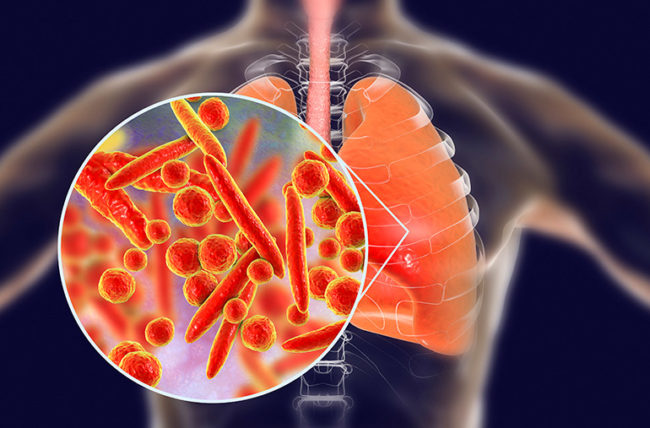

In [0]:
import os

from numpy.random import seed
from tensorflow import set_random_seed

In [0]:
os.environ['KAGGLE_USERNAME'] = "juniorosho"
os.environ['KAGGLE_KEY'] = "0d77c9fe1fd290700459161f517b35a2"

seed(100)
set_random_seed(100)

## 00.1 Funções auxiliares

In [0]:
def search_dir(type="normal", num=6):
  #Função auxiliar para verificar o conteúdo do diretório
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [0]:
def plot_images(type="normal", num=6):
  #Função auxiliar para plotar imagens
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # configurar as subparcelas na primeira chamada
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

# 01 Download das imagens, com bacteria com virus e normal. Kaffle Datasets

In [0]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #5 seconds

 99% 2.28G/2.29G [00:43<00:00, 34.0MB/s]
100% 2.29G/2.29G [00:43<00:00, 57.0MB/s]
CPU times: user 265 ms, sys: 49.6 ms, total: 315 ms
Wall time: 47.3 s


In [0]:
%time !unzip chest-xray-pneumonia.zip #10 seconds

In [0]:
%time !unzip chest_xray.zip #27 seconds

unzip:  cannot find or open chest_xray.zip, chest_xray.zip.zip or chest_xray.zip.ZIP.
CPU times: user 26.1 ms, sys: 9.58 ms, total: 35.7 ms
Wall time: 3.63 s


In [0]:
os.remove("chest-xray-pneumonia.zip") # limpa um pouco o diretório

# 02 Explore os Dados

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [0]:
#Aponte para os diretórios relevantes
train_dir = "chest_xray/train/"
val_dir   = "chest_xray/test/" #diretórios para treinamento

test_dir  = "chest_xray/val/" #diretório para pontuação do modelo final


In [0]:
search_dir(type="pneumonia", num=10)

person351_bacteria_1624.jpeg
person298_virus_617.jpeg
person504_bacteria_2130.jpeg
person337_bacteria_1564.jpeg
person124_virus_233.jpeg
person1178_virus_2004.jpeg
person1657_bacteria_4398.jpeg
person1156_bacteria_3101.jpeg
person995_virus_1676.jpeg
person299_bacteria_1417.jpeg


In [0]:
search_dir(type="normal", num=10)

IM-0673-0001.jpeg
IM-0537-0001.jpeg
IM-0754-0001.jpeg
IM-0605-0001.jpeg
IM-0234-0001.jpeg
IM-0598-0001.jpeg
NORMAL2-IM-0867-0001.jpeg
IM-0381-0001.jpeg
IM-0583-0001.jpeg
NORMAL2-IM-1177-0001.jpeg


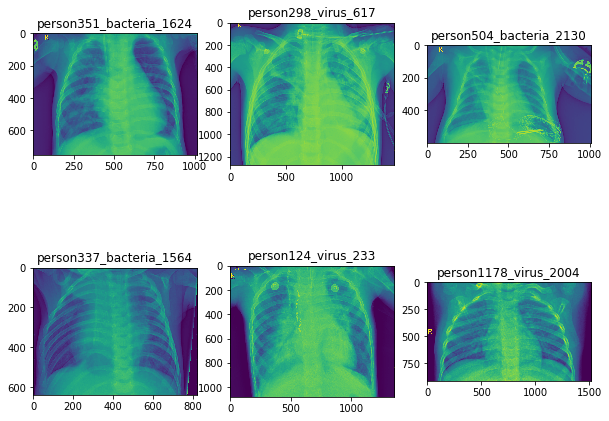

In [0]:
plot_images(type="pneumonia", num=6)

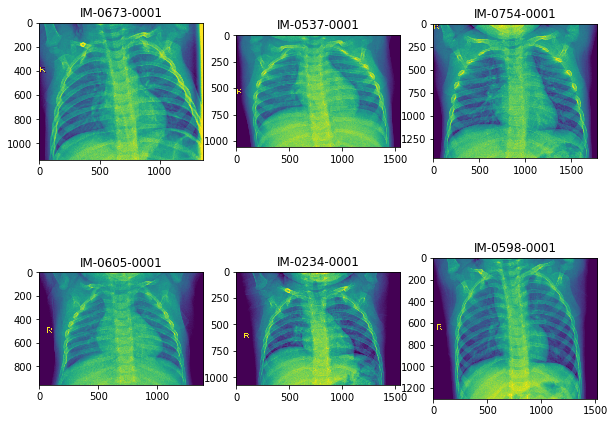

In [0]:
plot_images(type="normal", num=6)

# 03 Modelo

## 03.01 Modelo Pré-Treinado sem Transferência de Aprendizado

In [0]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image


Using TensorFlow backend.


In [0]:
pre_model = InceptionV3(weights='imagenet')















96116736/96112376 [==============================] - 3s 0us/step


In [0]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


In [0]:
img = mpimg.imread("example_2.jpg")
imgplot = plt.imshow(img)

FileNotFoundError: ignored

## 03.2 Preparação de dados

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size=163


#Criar gerador de dados de treinamento
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #Criar gerador de imagens em abstrato

In [0]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #diretório que contém dados de treinamento
        target_size=(150, 150), #que tamanho de imagem queremos
        batch_size=batch_size, #quantos arquivos para ler de cada vez
        class_mode="categorical") 

Found 5216 images belonging to 2 classes.


In [0]:
#Criar gerador de dados de validação

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 624 images belonging to 2 classes.


In [0]:
#Criar gerador de teste de validação

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 16 images belonging to 2 classes.


#03.03 Treinar o Modelo

In [0]:
import keras


In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Congele as camadas para não treinar
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #Cria Modelo Final



In [0]:
final_model.compile(loss ="categorical_crossentropy", #outro termo para perda de log
                    optimizer = "adam", 
                    metrics=["accuracy"])


In [0]:
fit_history = final_model.fit_generator(
        train_generator, #gerador de dados treinados
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validador dedos gerados
        validation_steps=len(val_generator))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
32/32 [==============================] - 77s 2s/step - loss: 0.6657 - acc: 0.8190 - val_loss: 1.0676 - val_acc: 0.6939
Epoch 2/5
32/32 [==============================] - 69s 2s/step - loss: 0.2450 - acc: 0.9086 - val_loss: 1.0931 - val_acc: 0.7163
Epoch 3/5
32/32 [==============================] - 70s 2s/step - loss: 0.2204 - acc: 0.9128 - val_loss: 2.0084 - val_acc: 0.6571
Epoch 4/5
32/32 [==============================] - 70s 2s/step - loss: 0.2243 - acc: 0.9091 - val_loss: 1.1797 - val_acc: 0.6506
Epoch 5/5
32/32 [==============================] - 70s 2s/step - loss: 0.2080 - acc: 0.9202 - val_loss: 1.1139 - val_acc: 0.6987


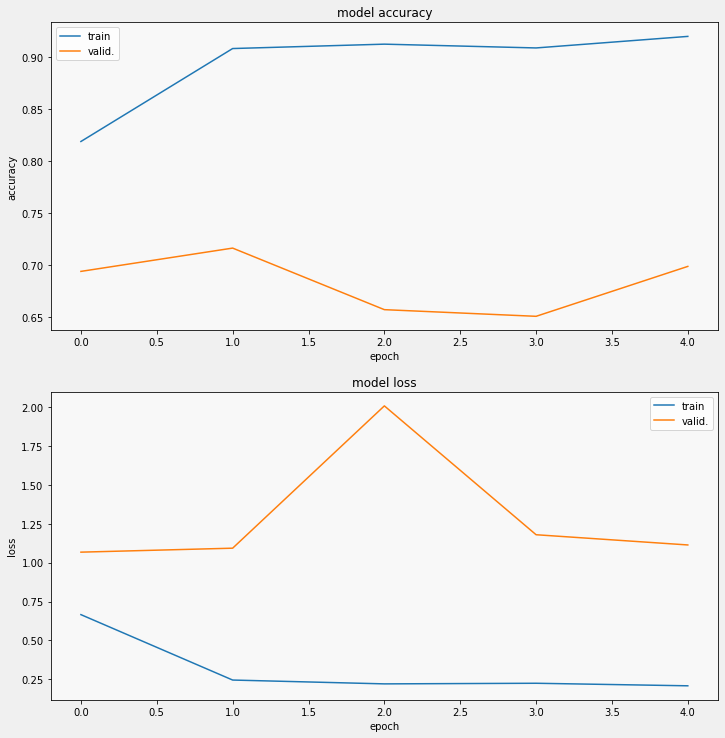

In [0]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [0]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.1161184720672281
Accuracy: 0.75


In [0]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [0]:
#Gere todas as previsões
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1])

In [0]:
#Gere true labels
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

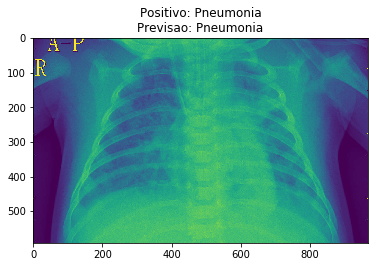

In [0]:
#@Caminho do arquivo, da imagem para testar
filename = "/content/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("Positivo: ", actual, "\n", "Previsao: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)

